In [92]:
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn.model_selection import train_test_split
from calendar import monthrange
import os, json
from rasterstats import zonal_stats
import rasterio
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# load datasets
project_files = "/home/sergei/Downloads/vkr/code_base/project_data/"
fires_path = project_files + "fires_with_factors/"
years = list(range(2015, 2025))
print(
    "Paths:", project_files, fires_path,
    "Years:", years, sep="\n"
)

fires_ds_l = []
for year_ in years:
    fires_geojson_path = fires_path + f"factor_dataset_{str(year_)}.geojson"
    ds = gpd.read_file(fires_geojson_path)
    fires_ds_l.append(ds)
print(f"Imported {len(fires_ds_l)} datasets")

Paths:
/home/sergei/Downloads/vkr/code_base/project_data/
/home/sergei/Downloads/vkr/code_base/project_data/fires_with_factors/
Years:
[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Imported 10 datasets


In [3]:
# print the first dataset as an example
print(
    "Shape:", fires_ds_l[0].shape, "Columns:", fires_ds_l[0].dtypes, 
    "(Non)fire ratio:", fires_ds_l[0].is_fire.value_counts(), sep="\n"
)
print("Nan values:\n", fires_ds_l[0].isnull().sum())
pd.options.display.max_columns = None   # show all columns
fires_ds_l[0].head(5)

Shape:
(2757, 27)
Columns:
year                        int32
lat                       float64
lon                       float64
event_date         datetime64[ms]
is_fire                     int32
grid_lat                  float64
grid_lon                  float64
T                         float64
RH                        float64
WIND_DIR_STD              float64
WIND_SPEED                float64
APCP                      float64
elevation                 float64
slope                     float64
aspect                    float64
vegetation_type           float64
road_type                  object
road_id                     int32
road_dist                 float64
river_id                    int32
river_dist                float64
locality_type              object
locality_id                object
locality_dist             float64
techno_obj_id               int32
techno_obj_dist           float64
geometry                 geometry
dtype: object
(Non)fire ratio:
is_fire
0    1660
1    1

,year,lat,lon,event_date,is_fire,grid_lat,grid_lon,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,vegetation_type,road_type,road_id,road_dist,river_id,river_dist,locality_type,locality_id,locality_dist,techno_obj_id,techno_obj_dist,geometry
0,2015,60.0217,115.8679,2015-07-16,1,60.0,116.0,18.295625,65.603125,105.826192,2.156250,0.928125,756.285714,3.867853,228.993504,21.0,прочая,152,193759.177102,228,21785.981741,село сельский,05.���,114105.573893,106,493120.164862,"POLYGON ((12897309.459 8403569.034, 12897309.1..."
1,2015,59.7178,115.0410,2015-08-06,1,59.5,115.0,16.455938,61.846875,108.147393,1.509375,0.296875,794.625000,4.589434,279.286755,1.0,прочая,152,231036.127592,219,23197.616858,село сельский,05.���,219916.158194,610,384503.700491,"POLYGON ((12805346.404 8336204.874, 12805346.1..."
2,2015,59.5761,113.9840,2015-09-25,1,59.5,114.0,0.158437,79.846875,118.414201,2.253125,0.200000,511.181818,7.200536,310.846270,11.0,прочая,152,281283.822800,220,1721.018231,село сельский,17.���,182717.515536,144,295530.312784,"POLYGON ((12687257.185 8304795.856, 12687256.7..."
3,2015,59.4877,113.6689,2015-09-24,1,59.5,113.5,0.922187,78.928125,128.074350,2.343750,0.215625,512.181818,2.837777,216.993585,15.0,прочая,152,312789.373320,220,25686.184906,село сельский,17.���,142391.828552,144,263925.972009,"POLYGON ((12653525.898 8287187.746, 12653525.7..."
4,2015,59.3922,114.0660,2015-07-12,1,59.5,114.0,19.102581,63.635484,90.308355,2.041935,0.361290,899.625000,5.854614,227.141216,1.0,прочая,152,316608.671509,220,15611.137720,поселок сельский,05.���,158680.082953,145,264187.329925,"POLYGON ((12696710.022 8264660.54, 12696709.73..."


In [4]:
# concatenate datasets
fires_dataset = pd.concat(fires_ds_l, ignore_index=True)
print("Shape:", fires_dataset.shape, 
      "Columns:", fires_dataset.dtypes,
      "(Non)fires ratio:", fires_dataset.is_fire.value_counts(), sep="\n"
)
print("Nan values:", fires_dataset.isnull().sum(), sep="\n")

Shape:
(19864, 27)
Columns:
year                        int32
lat                       float64
lon                       float64
event_date         datetime64[ms]
is_fire                     int32
grid_lat                  float64
grid_lon                  float64
T                         float64
RH                        float64
WIND_DIR_STD              float64
WIND_SPEED                float64
APCP                      float64
elevation                 float64
slope                     float64
aspect                    float64
vegetation_type           float64
road_type                  object
road_id                     int32
road_dist                 float64
river_id                    int32
river_dist                float64
locality_type              object
locality_id                object
locality_dist             float64
techno_obj_id               int32
techno_obj_dist           float64
geometry                 geometry
dtype: object
(Non)fires ratio:
is_fire
0    11537
1  

In [5]:
# what are some basic steps to do before training
# clean data:
# deal with the missing values (done), outliers (a z-score normalization) (not done)
# and inconsistencies (wrong naming or metrics, for ex, convert currencies to one unit or 
# word capitalization) (done)

# transform data:
# normalize data () or standardize it (use z-score ((a - mean) / std_dev) - read about the difference
# scale data (put it in a certain range)
# convert categorical data to numerical

# feature creation (create the new informative feature from the multiple existing)

# carefull with chronological order so that the past data doesn't leak to the test dataset

# reduce data
# dimensionality reduction (get rid of the data without losing information) - for ex, PCA

# balance the data (for ex, if fires are much more than non-fires)

# split data (the data should be balanced in both datasets)

# repeat the same operations for the test data (if you did it after splitting)
#

# Methods:
# z-score normalizatioin centers data distribution around 0, min-max scaling bounds values
# within specific range



# https://www.knime.com/blog/four-basic-steps-in-data-preparation
# https://www.knime.com/blog/seven-techniques-for-data-dimensionality-reduction
# https://www.pecan.ai/blog/data-preparation-for-machine-learning/
# https://lakefs.io/blog/machine-learning-data-preparation/
# https://www.techtarget.com/searchbusinessanalytics/feature/Data-preparation-in-machine-learning-6-key-steps
# https://www.datastax.com/guides/how-to-prepare-data-for-ai
# https://www.phdata.io/blog/how-to-prepare-data-for-use-in-machine-learning-models/
# https://www.researchgate.net/post/Do_we_need_to_standardize_variables_with_different_scales_before_doing_correlation_analysis
# 



In [6]:
# tried to do smth with locity type, decide to drop it for now
pd.get_dummies(fires_dataset.locality_type)
fires_dataset.locality_type.value_counts()
fires_dataset.locality_type.unique()
a = list(map(lambda x: x.replace(" ", "").lower(), fires_dataset.locality_type.unique()))
a
len(a), len(set(a))
set(a)
s = list(set(a))
p = len(s)
seen = []
for i in range(p):
    print(i)
    for j in range(p):
        if s[i] in s[j]:
            print(s[i], s[j])
    seen.append(s[i])

0
заимкасельский заимкасельский
1
поселок поселок
поселок рабочийпоселокгородской
поселок поселоксельский
поселок поселокж.д.станциисельский
2
город город
город рабочийпоселокгородской
город городгородской
3
рабочийпоселокгородской рабочийпоселокгородской
4
деревнясельский деревнясельский
5
деревнясльский деревнясльский
6
деревня деревнясельский
деревня деревнясльский
деревня деревня
7
блок-постсельский блок-постсельский
8
поселоксельский поселоксельский
9
городгородской городгородской
10
хуторсельский хуторсельский
11
район район
12
участоксельский участоксельский
13
поселокж.д.станциисельский поселокж.д.станциисельский
14
селосельский селосельский


In [7]:
fires_dataset.vegetation_type.value_counts().sort_index()

vegetation_type
1.0     1628
6.0      661
8.0      159
10.0     330
11.0    2449
12.0    4840
13.0     174
15.0    1461
17.0     956
18.0    6548
21.0     549
25.0     109
Name: count, dtype: int64

In [8]:
fires_dataset.columns

Index(['year', 'lat', 'lon', 'event_date', 'is_fire', 'grid_lat', 'grid_lon',
       'T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation', 'slope',
       'aspect', 'vegetation_type', 'road_type', 'road_id', 'road_dist',
       'river_id', 'river_dist', 'locality_type', 'locality_id',
       'locality_dist', 'techno_obj_id', 'techno_obj_dist', 'geometry'],
      dtype='object')

In [96]:
# save 2024 year as the test dataset before working with features
exclude_cols_test = [
    "event_date", "lat", "lon", "grid_lat", "grid_lon", "road_type", "road_id", 
    "river_id", "locality_id", "locality_type", "techno_obj_id", "geometry", 
]
test_ds = fires_dataset[fires_dataset.year == 2024]
test_ds = test_ds.loc[:, ~test_ds.columns.isin(exclude_cols_test)]
# write file
write_path = project_files + "train_data/"
if not os.path.exists(write_path):
    os.mkdir(write_path)
test_ds.to_csv(write_path + "test_dataset_2024.csv", sep=";")
print(test_ds.index)
test_ds.head(5)

Index([18314, 18315, 18316, 18317, 18318, 18319, 18320, 18321, 18322, 18323,
       ...
       19854, 19855, 19856, 19857, 19858, 19859, 19860, 19861, 19862, 19863],
      dtype='int64', length=1550)


,year,is_fire,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,vegetation_type,road_dist,river_dist,locality_dist,techno_obj_dist
18314,2024,1,16.133750,50.912500,129.970944,1.725000,0.025000,351.109375,0.862569,217.516313,18.0,422363.693609,40989.628659,139923.175317,772714.174606
18315,2024,1,24.109375,46.468750,119.376992,2.028125,0.025000,362.041667,0.860739,300.709934,18.0,426784.065997,42449.312116,140882.262596,771923.913271
18316,2024,1,23.584375,47.534375,141.419912,2.093750,0.015625,283.482759,1.586822,214.297013,18.0,614839.740231,2886.425311,125454.827189,804036.438063
18317,2024,1,19.822812,57.487500,100.166043,1.984375,0.118750,301.443662,1.479039,184.112328,1.0,602526.185900,0.000000,119364.982175,798698.850251
18318,2024,1,24.206562,40.284375,67.711544,2.431250,0.025000,345.325581,1.416153,183.756185,18.0,403076.886945,49023.719105,136235.692492,746352.437032


In [114]:
exclude_cols = [
    "event_date", "lat", "lon", "grid_lat", "grid_lon", "road_type", "road_id", 
    "river_id", "locality_id", "locality_type", "techno_obj_id", "geometry", "year"
]
# exlude 2024 year
train_dataset = fires_dataset[fires_dataset.year != 2024]
print(fires_dataset.shape, train_dataset[train_dataset.year == 2024].shape, train_dataset.index.duplicated().sum())
train_dataset.reset_index(drop=True, inplace=True)
print(train_dataset.index)
train_dataset = train_dataset.loc[:, ~(train_dataset.columns.isin(exclude_cols))].round(decimals=6)
train_dataset["vegetation_type"] = train_dataset["vegetation_type"].astype(int)
print(train_dataset.shape, train_dataset.shape[0] - fires_dataset.shape[0], train_dataset.dtypes, sep="\n")
train_dataset.head(5)

(19864, 27) (0, 27) 0
RangeIndex(start=0, stop=18314, step=1)
(18314, 14)
-1550
is_fire              int32
T                  float64
RH                 float64
WIND_DIR_STD       float64
WIND_SPEED         float64
APCP               float64
elevation          float64
slope              float64
aspect             float64
vegetation_type      int64
road_dist          float64
river_dist         float64
locality_dist      float64
techno_obj_dist    float64
dtype: object


,is_fire,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,vegetation_type,road_dist,river_dist,locality_dist,techno_obj_dist
0,1,18.295625,65.603125,105.826192,2.156250,0.928125,756.285714,3.867853,228.993504,21,193759.177102,21785.981741,114105.573893,493120.164862
1,1,16.455938,61.846875,108.147393,1.509375,0.296875,794.625000,4.589434,279.286755,1,231036.127592,23197.616858,219916.158194,384503.700491
2,1,0.158437,79.846875,118.414201,2.253125,0.200000,511.181818,7.200536,310.846270,11,281283.822800,1721.018231,182717.515536,295530.312784
3,1,0.922187,78.928125,128.074350,2.343750,0.215625,512.181818,2.837777,216.993585,15,312789.373320,25686.184906,142391.828552,263925.972009
4,1,19.102581,63.635484,90.308355,2.041935,0.361290,899.625000,5.854614,227.141216,1,316608.671509,15611.137720,158680.082953,264187.329925


<Axes: >

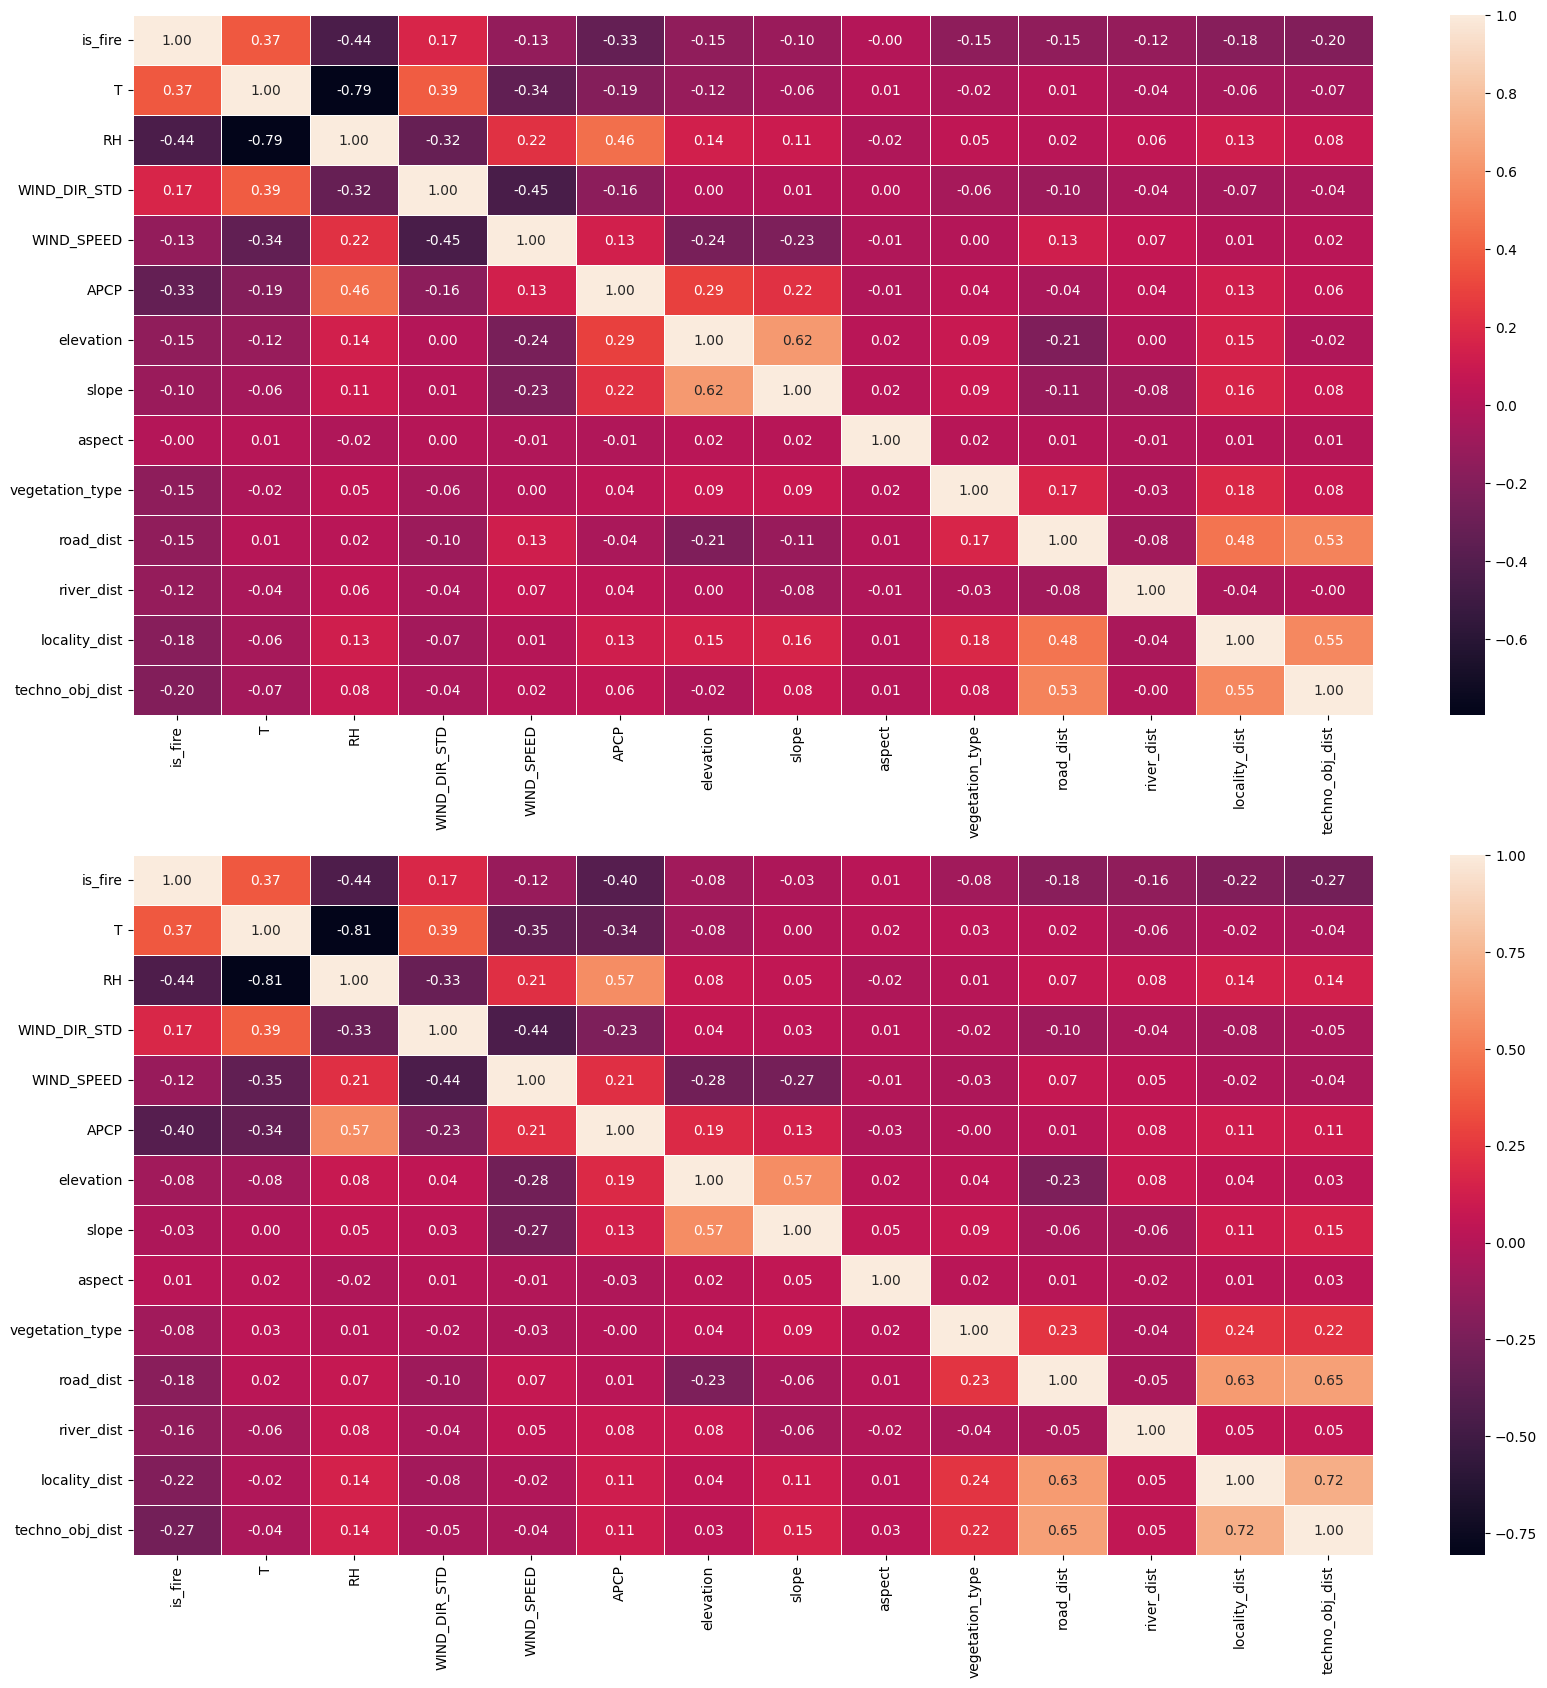

In [116]:
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 1)
pr = train_dataset.corr(method="pearson")
sp = train_dataset.corr(method="spearman")
# pr.loc[["WIND_DIR_STD", "WIND_SPEED"], :]
# sp.loc[["WIND_DIR_STD", "WIND_SPEED"], :]
sns.heatmap(pr, annot=True, linewidths=0.5, fmt=".2f", ax=ax[0])
sns.heatmap(sp, annot=True, linewidths=0.5, fmt=".2f", ax=ax[1])

In [118]:
# standardize using z-score only numeical variables (without the target and the categorical variable)
ex_cols = ["vegetation_type", "is_fire"]
train_ds_ = train_dataset.loc[:, ~train_dataset.columns.isin(ex_cols)]
train_ds_ = (train_ds_ - train_ds_.mean()) / train_ds_.std()
train_ds = train_ds_.join(train_dataset["is_fire"])
print(train_ds.columns, train_ds.index, sep="\n")
train_ds.describe()

Index(['T', 'RH', 'WIND_DIR_STD', 'WIND_SPEED', 'APCP', 'elevation', 'slope',
       'aspect', 'road_dist', 'river_dist', 'locality_dist', 'techno_obj_dist',
       'is_fire'],
      dtype='object')
RangeIndex(start=0, stop=18314, step=1)


,T,RH,WIND_DIR_STD,WIND_SPEED,APCP,elevation,slope,aspect,road_dist,river_dist,locality_dist,techno_obj_dist,is_fire
count,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,1.831400e+04,18314.000000
mean,1.718742e-16,-3.321091e-16,3.103823e-16,1.676065e-16,-4.966117e-17,1.842895e-16,-1.489835e-16,3.026228e-17,-1.862294e-17,1.078579e-16,-3.724588e-17,5.121308e-17,0.418314
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.493296
min,-3.914048e+00,-2.558692e+00,-2.984924e+00,-2.393809e+00,-9.999546e-01,-1.565655e+00,-9.704052e-01,-2.011248e+00,-1.037360e+00,-1.102186e+00,-1.098392e+00,-7.927010e-01,0.000000
25%,-8.037713e-01,-8.375681e-01,-6.984281e-01,-7.270864e-01,-6.964101e-01,-6.516270e-01,-6.256266e-01,-7.465279e-01,-8.001115e-01,-7.478202e-01,-8.065635e-01,-6.213588e-01,0.000000
50%,2.372381e-02,1.179366e-01,3.316001e-02,-1.097820e-01,-2.627750e-01,-2.890704e-01,-3.569128e-01,-2.557413e-02,-3.750827e-01,-2.313803e-01,-2.790352e-01,-3.632780e-01,0.000000
75%,8.899267e-01,8.569242e-01,7.062828e-01,5.917004e-01,3.735178e-01,3.884737e-01,2.748553e-01,7.185538e-01,5.700624e-01,4.723823e-01,5.317000e-01,1.309429e-01,1.000000
max,1.995291e+00,1.581765e+00,3.408117e+00,5.221484e+00,1.238698e+01,7.066831e+00,8.730675e+00,2.093958e+00,2.998649e+00,6.161479e+00,4.208118e+00,5.110807e+00,1.000000


In [119]:
# pearson correlation with pvalue (using train_ds)
# train_ds = train_dataset.loc[:, ~train_dataset.columns.isin(["vegetation_type", "year"])]
pearson_corr_d = {}
moderate_pearson_corr_d = {}
strong_pearson_corr_d = {}
for i in range(train_ds.shape[1]):
    col = train_ds.iloc[:, i]
    print(f"Checking column {col.name}")
    pearson_corr_d[col.name] = {}
    moderate_pearson_corr_d[col.name] = {}
    strong_pearson_corr_d[col.name] = {}
    for j in range(train_ds.shape[1]):
        col_ = train_ds.iloc[:, j]
        r, p_value = st.pearsonr(col, col_)
        print(f"{col.name} {col_.name} Coeff: {r}, p_value: {p_value}")
        if p_value < 0.05:
            print("Correlation exists")
            pearson_corr_d[col.name][col_.name] = r
            if 0.3 <= abs(r) < 0.5:
                moderate_pearson_corr_d[col.name][col_.name] = r
            elif abs(r) >= 0.5:
                strong_pearson_corr_d[col.name][col_.name] = r
        else:
            print("Correlation doesn't exist")
    print("\n")
print(
    "All",
    json.dumps(pearson_corr_d, indent=4), 
    "Moderate:",
    json.dumps(moderate_pearson_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_pearson_corr_d, indent=4),
    sep="\n"
)

Checking column T
T T Coeff: 1.0, p_value: 0.0
Correlation exists
T RH Coeff: -0.794772438264966, p_value: 0.0
Correlation exists
T WIND_DIR_STD Coeff: 0.3855946884685186, p_value: 0.0
Correlation exists
T WIND_SPEED Coeff: -0.3421037640629616, p_value: 0.0
Correlation exists
T APCP Coeff: -0.1924494618723191, p_value: 2.6060481590541215e-152
Correlation exists
T elevation Coeff: -0.11501342916566518, p_value: 5.7133570512346335e-55
Correlation exists
T slope Coeff: -0.060238116296311955, p_value: 3.382837112704154e-16
Correlation exists
T aspect Coeff: 0.01270392057072649, p_value: 0.08558455273638568
Correlation doesn't exist
T road_dist Coeff: 0.012147040969541927, p_value: 0.10021791080442749
Correlation doesn't exist
T river_dist Coeff: -0.0443526488528177, p_value: 1.9162122814761577e-09
Correlation exists
T locality_dist Coeff: -0.05745418447484949, p_value: 7.188111835598555e-15
Correlation exists
T techno_obj_dist Coeff: -0.06530808791415163, p_value: 8.995570986596749e-19
Cor

In [120]:
# spearman correlation with pvalue (using train_ds)
# train_ds = train_dataset.loc[:, ~train_dataset.columns.isin(["vegetation_type", "year"])]
spearman_corr_d = {}
moderate_spearman_corr_d = {}
strong_spearman_corr_d = {}
for i in range(train_ds.shape[1]):
    col = train_ds.iloc[:, i]
    print(f"Checking column {col.name}")
    spearman_corr_d[col.name] = {}
    moderate_spearman_corr_d[col.name] = {}
    strong_spearman_corr_d[col.name] = {}
    for j in range(train_ds.shape[1]):
        col_ = train_ds.iloc[:, j]
        r, p_value = st.spearmanr(col, col_)
        print(f"{col.name} {col_.name} Coeff: {r}, p_value: {p_value}")
        if p_value < 0.05:
            print("Correlation exists")
            spearman_corr_d[col.name][col_.name] = r
            if 0.3 <= abs(r) < 0.5:
                moderate_spearman_corr_d[col.name][col_.name] = r
            elif abs(r) >= 0.5:
                strong_spearman_corr_d[col.name][col_.name] = r
        else:
            print("Correlation doesn't exist")
    print("\n")
print(
    "All",
    json.dumps(spearman_corr_d, indent=4), 
    "Moderate:",
    json.dumps(moderate_spearman_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_spearman_corr_d, indent=4),
    sep="\n"
)

Checking column T
T T Coeff: 1.0, p_value: 0.0
Correlation exists
T RH Coeff: -0.807261366124065, p_value: 0.0
Correlation exists
T WIND_DIR_STD Coeff: 0.39178110364997043, p_value: 0.0
Correlation exists
T WIND_SPEED Coeff: -0.3496373369989826, p_value: 0.0
Correlation exists
T APCP Coeff: -0.34243421357937925, p_value: 0.0
Correlation exists
T elevation Coeff: -0.07564645086572526, p_value: 1.1692326963654188e-24
Correlation exists
T slope Coeff: 0.00296504493201573, p_value: 0.6882502535782125
Correlation doesn't exist
T aspect Coeff: 0.019856279636995912, p_value: 0.007205023786283671
Correlation exists
T road_dist Coeff: 0.020228626278576575, p_value: 0.006188598549145264
Correlation exists
T river_dist Coeff: -0.06483026675099195, p_value: 1.6049288798336822e-18
Correlation exists
T locality_dist Coeff: -0.019783944568293587, p_value: 0.007419041080798497
Correlation exists
T techno_obj_dist Coeff: -0.039238025338724954, p_value: 1.0858661433782838e-07
Correlation exists
T is_fir

(13, 13) (13, 13)


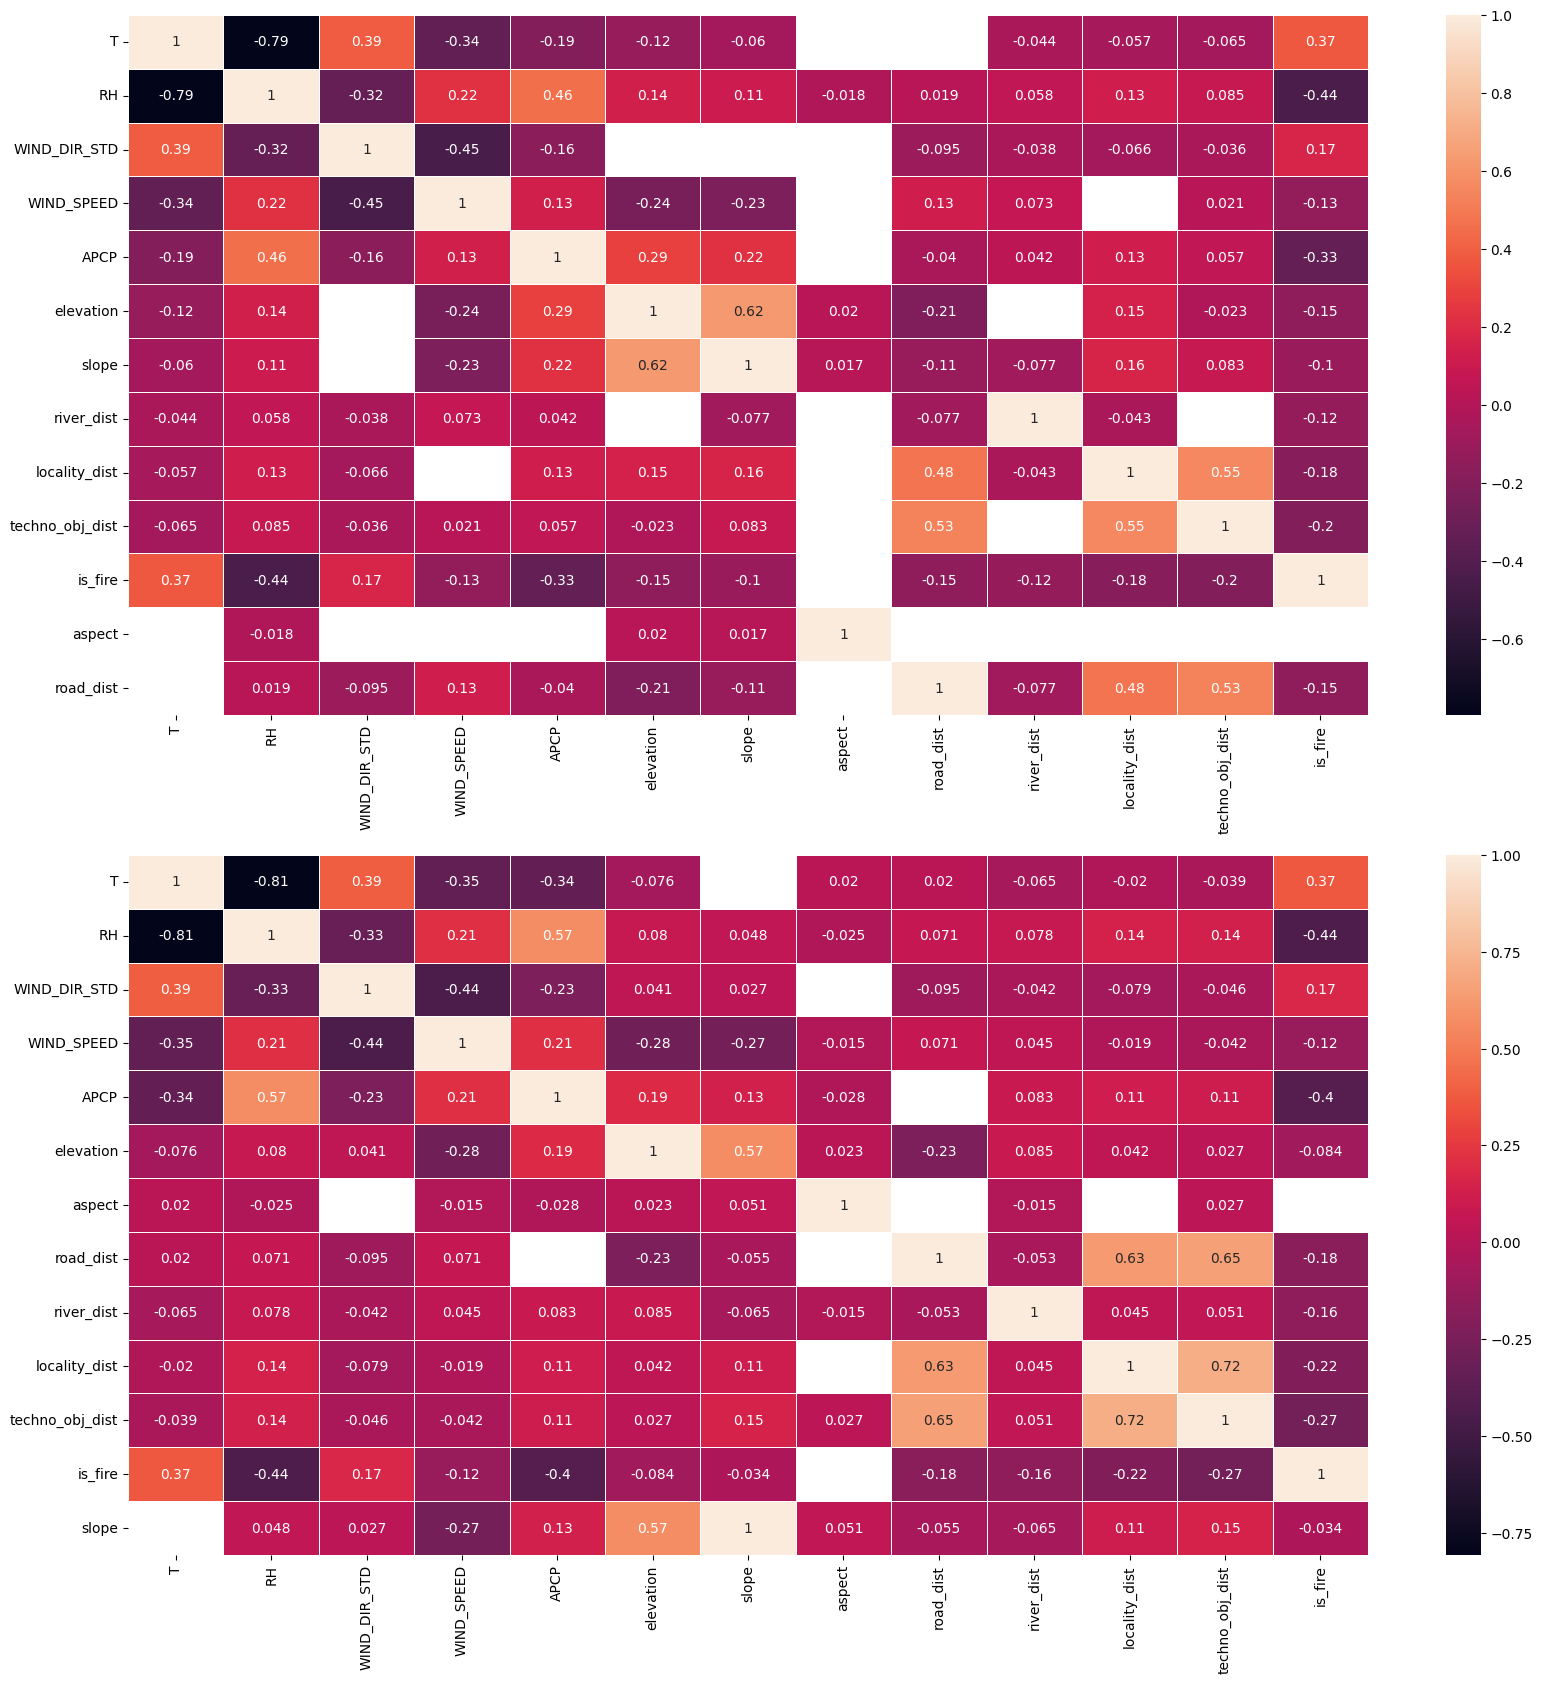

In [121]:
# correlations matrix
fig = plt.figure(figsize=(20, 20))
ax = fig.subplots(2, 1)
pearson_m = pd.DataFrame(pearson_corr_d)
spearman_m = pd.DataFrame(spearman_corr_d)
print(pearson_m.shape, spearman_m.shape)
sns.heatmap(pearson_m, annot=True, ax=ax[0], linewidths=0.5)
sns.heatmap(spearman_m, annot=True, ax=ax[1], linewidths=0.5)
fig.savefig("out.png")

In [122]:
# features: is_fire, T, RH, wind_dir_std, wind_speed, apcp, elevation, slope, aspect
# road_dist, river_dist, locality_dist, techno_obj_dist
# highly correlated features
# pearson: T - RH, elevation - slope, road_dist - techno_obj_dist, locality_dist - techno_obj_dist
# spearman: T - RH, RH - apcp, elevation - slope, road_dist - locality_dist & techno_obj_dist, locality_dist - 
# techno_obj_dist
# VIF > 5: RH, wind_dir, wind_speed, elevation    
print(
    "Pearson",
    "Moderate:",
    json.dumps(moderate_pearson_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_pearson_corr_d, indent=4),
    "\nSpearman",
    "Moderate:",
    json.dumps(moderate_spearman_corr_d, indent=4),
    "Strong:",
    json.dumps(strong_spearman_corr_d, indent=4),
    sep="\n"
)

Pearson
Moderate:
{
    "T": {
        "WIND_DIR_STD": 0.3855946884685186,
        "WIND_SPEED": -0.3421037640629616,
        "is_fire": 0.3693530525365671
    },
    "RH": {
        "WIND_DIR_STD": -0.3221613941492673,
        "APCP": 0.4579367129485222,
        "is_fire": -0.4396441329656173
    },
    "WIND_DIR_STD": {
        "T": 0.3855946884685186,
        "RH": -0.3221613941492673,
        "WIND_SPEED": -0.44625101691198865
    },
    "WIND_SPEED": {
        "T": -0.3421037640629616,
        "WIND_DIR_STD": -0.44625101691198865
    },
    "APCP": {
        "RH": 0.4579367129485222,
        "is_fire": -0.3292709179028366
    },
    "elevation": {},
    "slope": {},
    "aspect": {},
    "road_dist": {
        "locality_dist": 0.47656136118613507
    },
    "river_dist": {},
    "locality_dist": {
        "road_dist": 0.47656136118613507
    },
    "techno_obj_dist": {},
    "is_fire": {
        "T": 0.3693530525365671,
        "RH": -0.4396441329656173,
        "APCP": -0.3292709

In [123]:
# VIF (for features_ds)
features_ds = train_ds.loc[:, ~train_ds.columns.isin(["is_fire"])].join(train_dataset.vegetation_type)
VIF = pd.DataFrame()
VIF["feature"] = list(features_ds.columns)
VIF["VIF"] = [variance_inflation_factor(features_ds.values, i) for i in range(features_ds.shape[1])] 
VIF

,feature,VIF
0,T,3.607181
1,RH,3.890444
2,WIND_DIR_STD,1.375929
3,WIND_SPEED,1.552719
4,APCP,1.629453
5,elevation,1.931264
6,slope,1.709923
7,aspect,1.001340
8,road_dist,1.709071
9,river_dist,1.029089


In [124]:
# gr = sns.pairplot(train_dataset)
# gr.fig.savefig("out1.png")
# train_ds.columns

# {'SOILW40': 'Влажность почвы (в слое 10-40см), %',
#  'SOILW200': 'Влажность почвы (в слое 100-200см), %',
#  'TMIN': 'Минимальная температура, °С',
#  'SNOD': 'Глубина снега, м',
#  'TMPGR40': 'Температура почвы (в слое 10-40см), °С',
#  'T': 'Температура, °С',
#  'DATE': 'Дата',
#  'WIND_SPEED': 'Скорость ветра, м/c',
#  'TMPGR100': 'Температура почвы (в слое 40-100см), °С',
#  'LAT': 'Широта, °',
#  'TMPGR10': 'Температура почвы (в слое 0-10см), °С',
#  'LON': 'Долгота, °',
#  'TMAX': 'Максимальная температура, °С',
#  'RH': 'Относительная влажность, %',
#  'APCP': 'Количество осадков, кг/м2',
#  'TIME': 'Время',
#  'WIND_DIR': 'Направление ветра, °',
#  'TMPGR200': 'Температура почвы (в слое 100-200см), °С',
#  'SOILW10': 'Влажность почвы (в слое 0-10см), %',
#  'SOILW100': 'Влажность почвы (в слое 40-100см), %'}

In [125]:
# T because it's less correlated with the target than RH, 
# locality_dist because its highly correlated with techno_obj_dist (0.71), and the last is more correlated
# with the target
# slope because it's highly correlated with the elevation and less correlated with the target than elevation
ex = ["T", "locality_dist", "slope"]
ds = features_ds.loc[:, ~features_ds.columns.isin(ex)]
VIF = pd.DataFrame()
VIF["feature"] = list(ds.columns)
VIF["VIF"] = [variance_inflation_factor(ds.values, i) for i in range(ds.shape[1])] 
print(VIF["VIF"].mean())
VIF

1.2768401722223395


,feature,VIF
0,RH,1.393074
1,WIND_DIR_STD,1.350805
2,WIND_SPEED,1.401773
3,APCP,1.376390
4,elevation,1.260233
5,aspect,1.001312
6,road_dist,1.524765
7,river_dist,1.017195
8,techno_obj_dist,1.436597
9,vegetation_type,1.006258


In [126]:
# write file
write_path = project_files + "train_data/"
if not os.path.exists(write_path):
    os.mkdir(write_path)
a = ds.join(train_dataset.is_fire)
a.to_csv(write_path + "dataset_with_feature_dropped.csv", sep=";")
print(a.index)
b = features_ds.join(train_dataset.is_fire)
b.to_csv(write_path + "dataset.csv", sep=";")
print(b.index)

RangeIndex(start=0, stop=18314, step=1)
RangeIndex(start=0, stop=18314, step=1)
